<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Тема 2. Визуальный анализ данных с Python
## <center>Часть 2. Пример визуального анализа данных

Считываем в DataFrame знакомые нам по [первой статье](https://habrahabr.ru/company/ods/blog/322626/) данные по оттоку клиентов телеком-оператора. 

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 100)
import pylab as plt
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10, 8)

In [2]:
df = pd.read_csv('../../data/telecom_churn.csv')

Проверим, все ли нормально считалось – посмотрим на первые 5 строк (метод `head`).

In [3]:
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


Число строк (клиентов) и столбцов (признаков):

In [4]:
df.shape

(3333, 20)

Посмотрим на признаки и убедимся, что пропусков ни в одном из них нет – везде по 3333 записи.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
State                     3333 non-null object
Account length            3333 non-null int64
Area code                 3333 non-null int64
International plan        3333 non-null object
Voice mail plan           3333 non-null object
Number vmail messages     3333 non-null int64
Total day minutes         3333 non-null float64
Total day calls           3333 non-null int64
Total day charge          3333 non-null float64
Total eve minutes         3333 non-null float64
Total eve calls           3333 non-null int64
Total eve charge          3333 non-null float64
Total night minutes       3333 non-null float64
Total night calls         3333 non-null int64
Total night charge        3333 non-null float64
Total intl minutes        3333 non-null float64
Total intl calls          3333 non-null int64
Total intl charge         3333 non-null float64
Customer service calls    3333 non-null int64


Описание признаков

|  Название  | Описание | Тип |
|---         |--:       |     |
| **State** | Буквенный код штата | номинальный |
| **Account length** | Как долго клиент обслуживается компанией | количественный |
| **Area code** | Префикс номера телефона | количественный  |
| **International plan** | Международный роуминг  (подключен/не подключен) | бинарный |
| **Voice mail plan** | Голосовая почта (подключена/не подключена) | бинарный |
| **Number vmail messages** | Количество голосовых сообщений | количественный |
| **Total day minutes** |  Общая длительность разговоров днем | количественный |
| **Total day calls** | Общее количество звонков днем | количественный |
| **Total day charge** | Общая сумма оплаты за услуги днем | количественный |
| **Total eve minutes** | Общая длительность разговоров вечером | количественный |
| **Total eve calls** | Общее количество звонков вечером | количественный |
| **Total eve charge** | Общая сумма оплаты за услуги вечером | количественный |
| **Total night minutes** | Общая длительность разговоров ночью | количественный |
| **Total night calls** | Общее количество звонков ночью | количественный |
| **Total night charge** | Общая сумма оплаты за услуги ночью | количественный |
| **Total intl minutes** | Общая длительность международных разговоров | количественный |
| **Total intl calls** | Общее количество международных разговоров | количественный |
| **Total intl charge** | Общая сумма оплаты за международные разговоры | количественный |
| **Customer service calls** | Число обращений в сервисный центр | количественный |

Целевая переменная: **Churn** – Признак оттока, бинарный (1 – потеря клиента, то есть отток). Потом мы будем строить модели, прогнозирующие этот признак по остальным, поэтому мы и назвали его целевым. 

Посмотрим на распределение целевого класса – оттока клиентов.

In [6]:
df['Churn'].value_counts()

False    2850
True      483
Name: Churn, dtype: int64

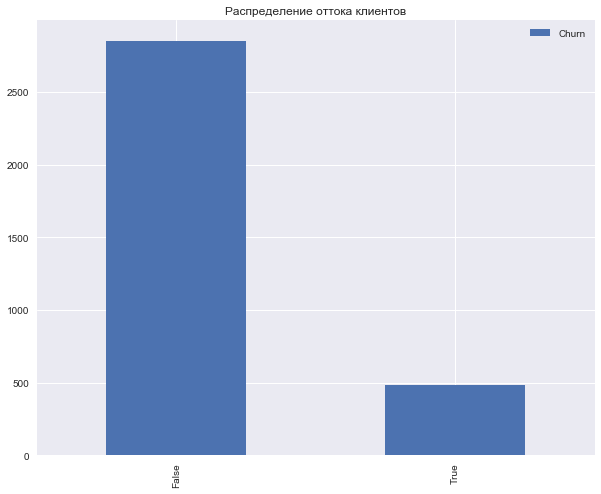

In [7]:
df['Churn'].value_counts().plot(kind='bar', label='Churn')
plt.legend()
plt.title('Распределение оттока клиентов');

Выделим следующие группы признаков (среди всех кроме *Churn* ):
 - бинарные: *International plan*, *Voice mail plan*
 - категориальные: *State*
 - порядковые: *Customer service calls*
 - количественные: все остальные

Посмотрим на корреляции количественных признаков. По раскрашенной матрице корреляций видно, что такие признаки как *Total day charge* считаются по проговоренным минутам (*Total day minutes*). То есть 4 признака можно выкинуть, они не несут полезной информации.

In [8]:
corr_matrix = df.drop(['State', 'International plan', 'Voice mail plan',
                      'Area code'], axis=1).corr()

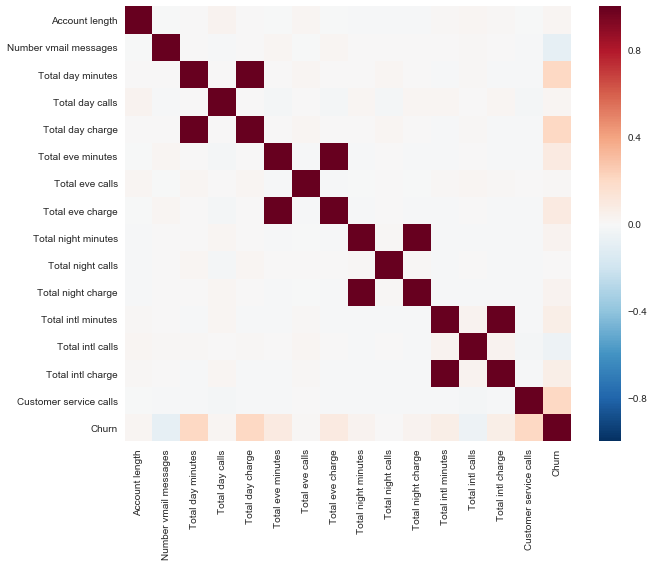

In [9]:
sns.heatmap(corr_matrix);

Теперь посмотрим на распределения всех интересующих нас количественных признаков. На бинарные/категориальные/порядковые признакие будем смотреть отдельно.

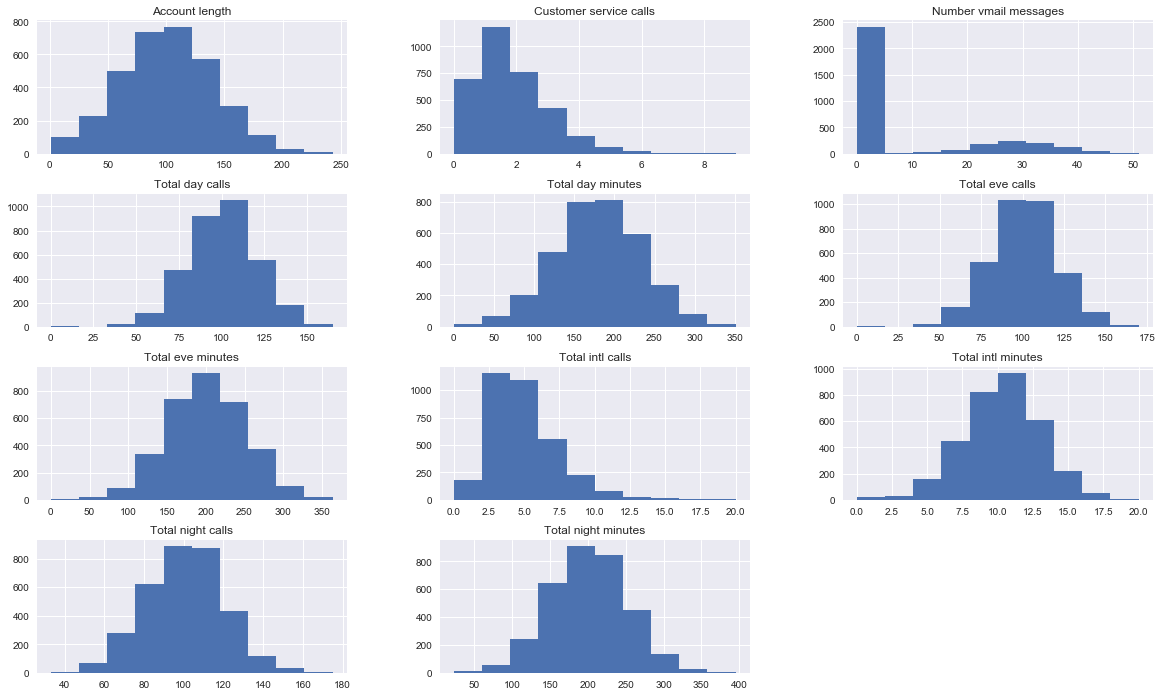

In [10]:
features = list(set(df.columns) - set(['State', 'International plan', 'Voice mail plan',  'Area code',
                                      'Total day charge',   'Total eve charge',   'Total night charge',
                                        'Total intl charge', 'Churn']))

df[features].hist(figsize=(20,12));

Видим, что большинство признаков распределены нормально. Исключения – число звонков в сервисный центр (*Customer service calls*) (тут больше подходит пуассоновское распределение) и число голосовых сообщений (*Number vmail messages*, пик в нуле, т.е. это те, у кого голосовая почта не подключена). Также смещено распределение числа международных звонков (*Total intl calls*).

Еще полезно строить вот такие картинки, где на главной диагонали рисуются распределения признаков, а вне главной диагонали – диаграммы рассеяния для пар признаков. Бывает, что это приводит к каким-то выводам, но в данном случае все примерно понятно, без сюрпризов. 

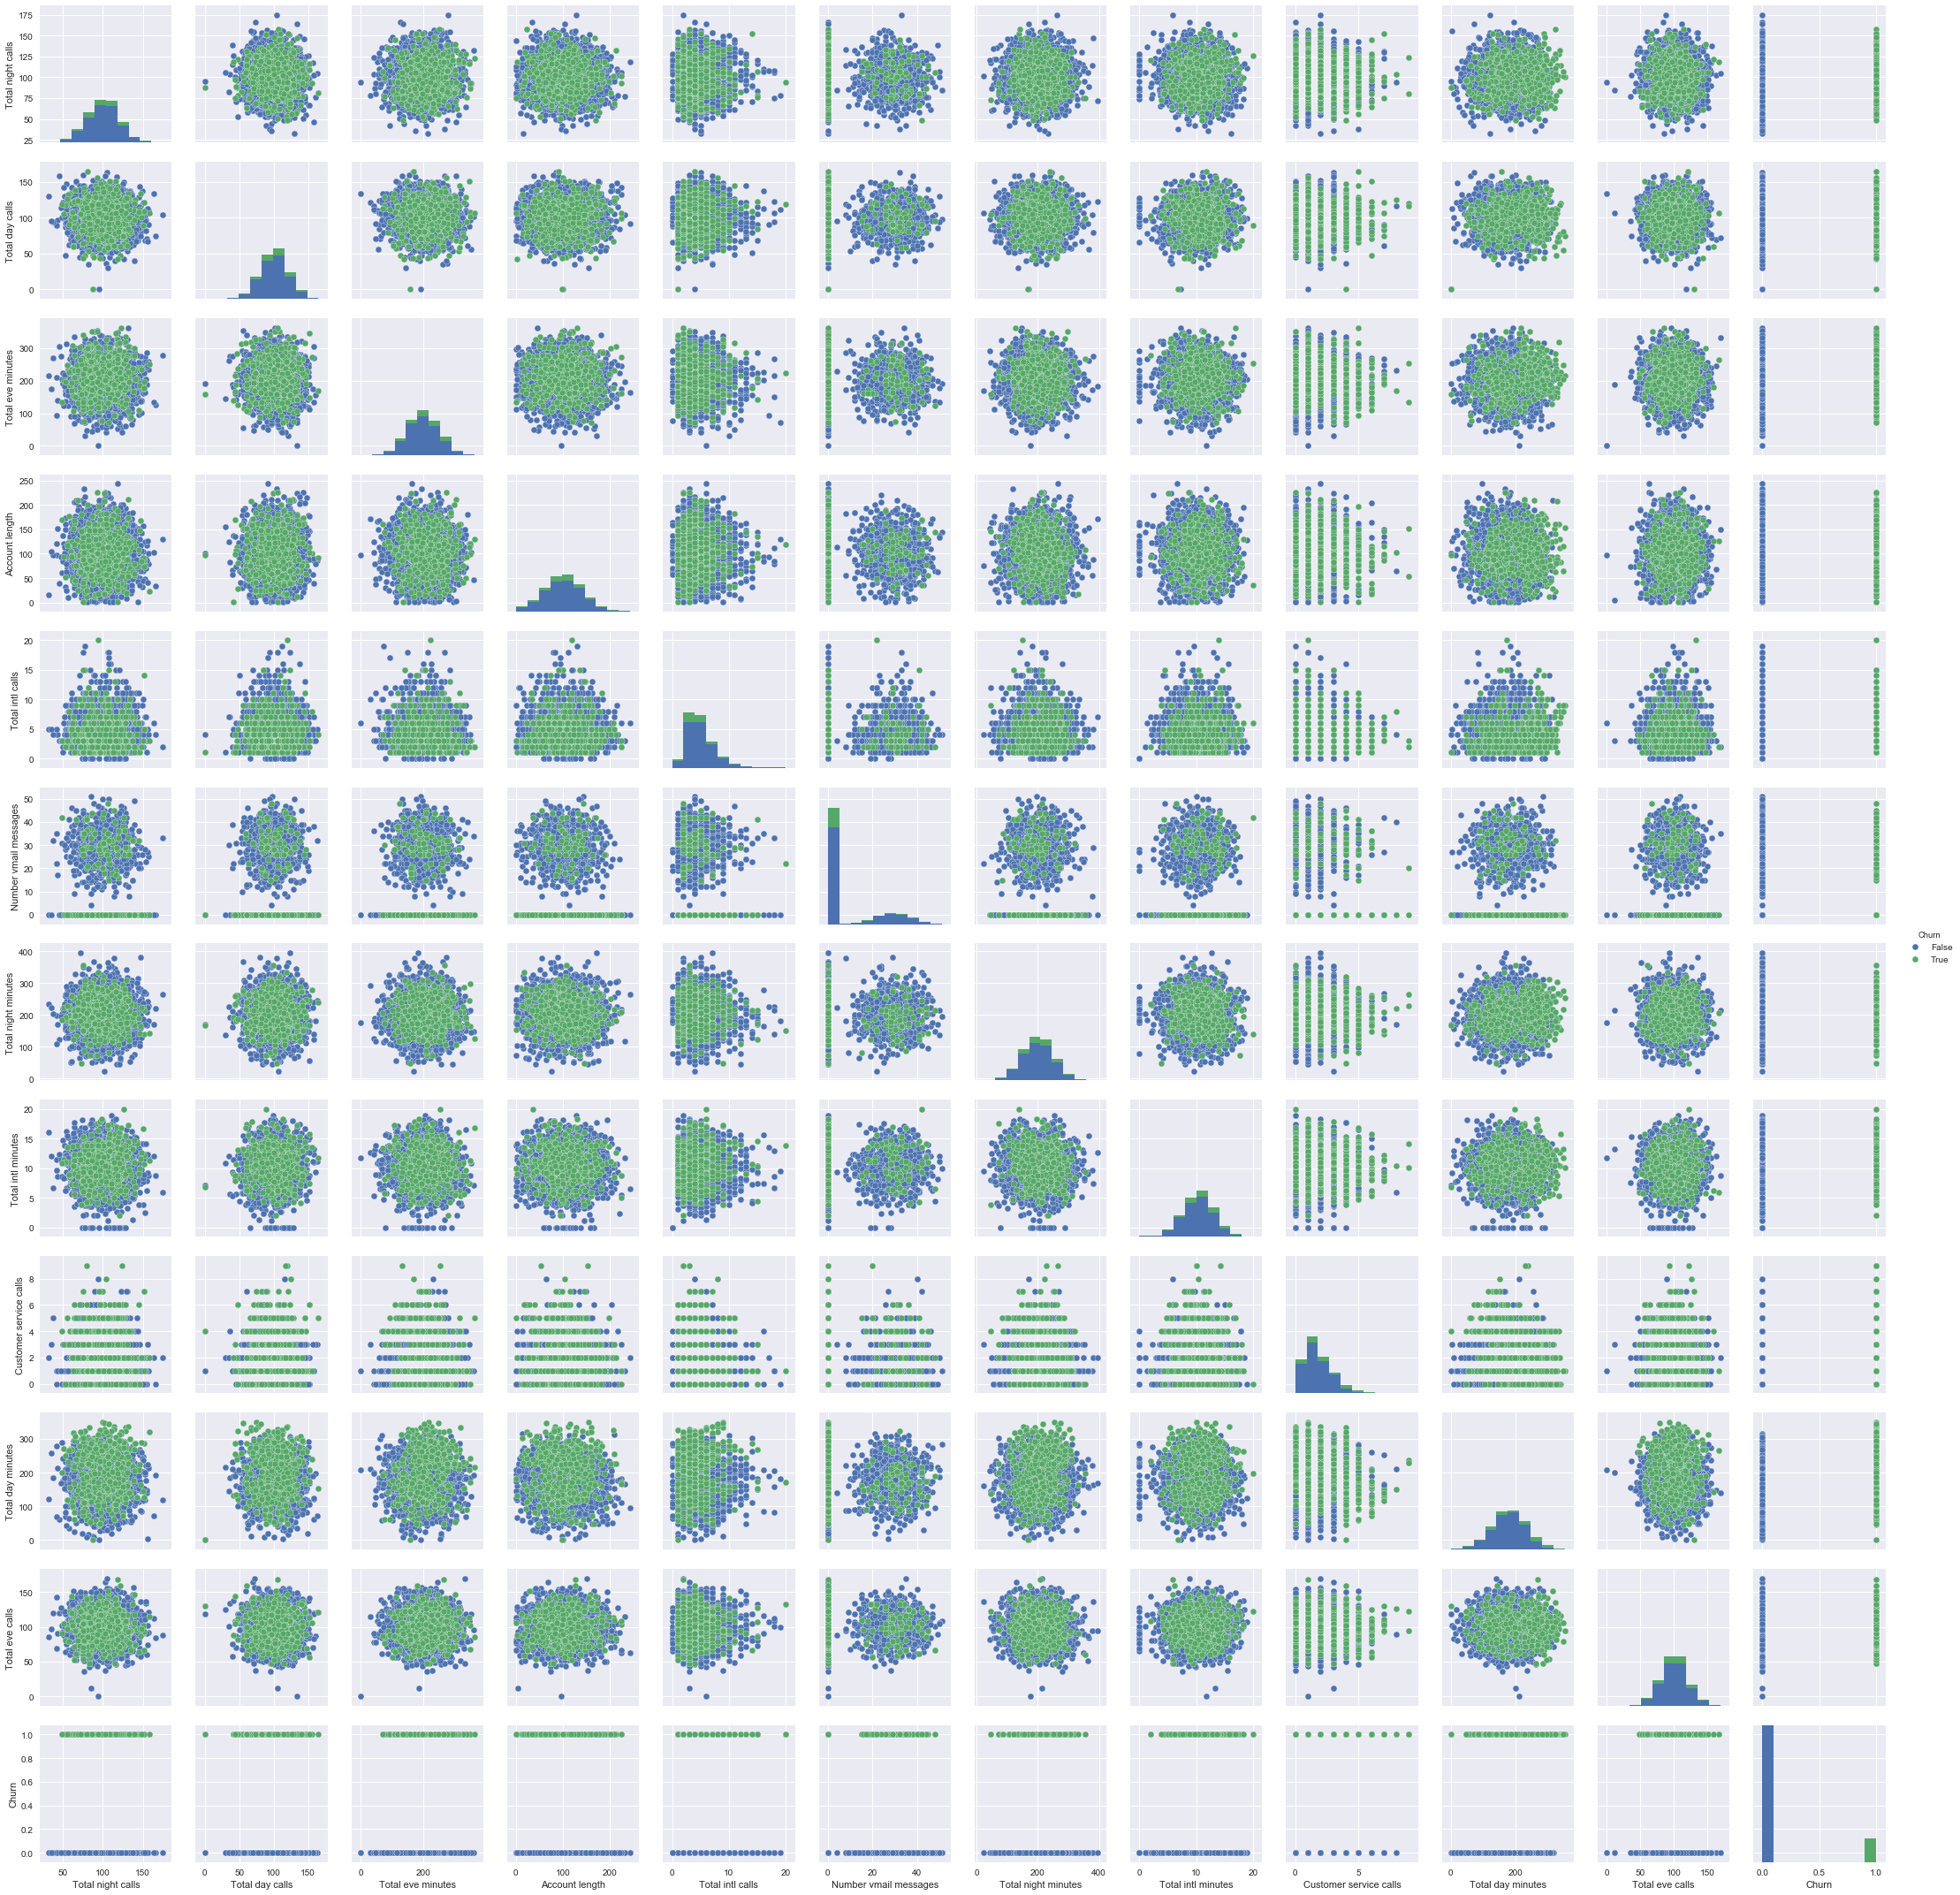

In [11]:
sns.pairplot(df[features + ['Churn']], hue='Churn');

**Дальше посмотрим, как признаки связаны с целевым – с оттоком.**



Построим boxplot-ы, описывающее статистики распределения количественных признаков в двух группах: среди лояльных и ушедших клиентов. 

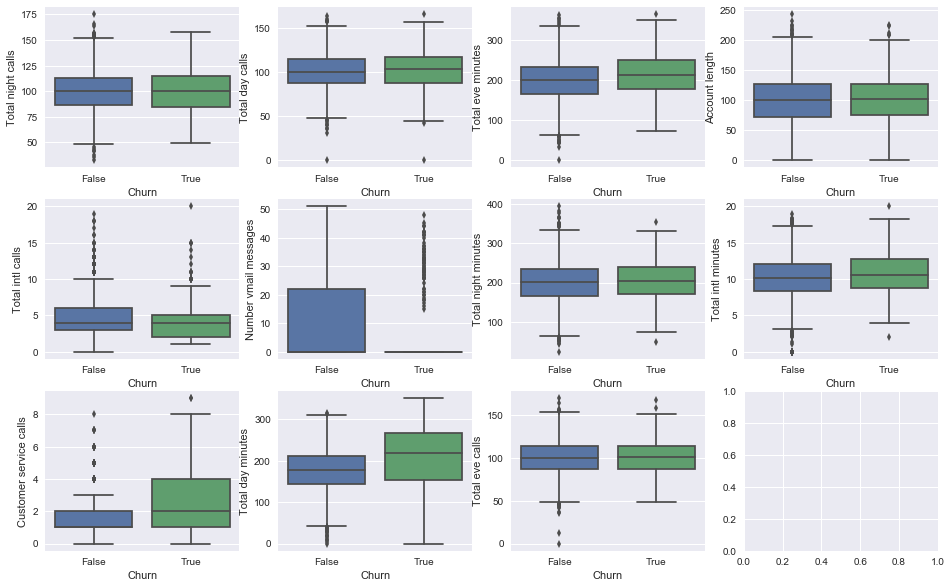

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, feat in  enumerate(features):
    sns.boxplot(x='Churn', y=feat, data=df, ax=axes[int(idx / 4), idx % 4])
    axes[int(idx / 4), idx % 4].legend()
    axes[int(idx / 4), idx % 4].set_xlabel('Churn')
    axes[int(idx / 4), idx % 4].set_ylabel(feat);

На глаз наибольшее отличие мы видим для признаков *Total day minutes*, *Customer service calls* и *Number vmail messages*. Впоследствии мы научимся определять важность признаков в задаче классификации с помощью случайного леса (или градиентного бустинга), и окажется, что первые два – действительно очень важные признаки для прогнозирования оттока.

Посмотрим отдельно на картинки с распределением кол-ва проговоренных днем минут среди лояльных/ушедших. Слева - знакомые нам боксплоты, справа – сглаженные гистограммы распределения числового признака в двух группах (скорее просто красивая картинка, все и так понятно по боксплоту).

Интересное **наблюдение:** в среднем ушедшие клиенты больше пользуются связью. Возможно, они недовольны тарифами, и одной из мер борьбы с оттоком будет понижение тарифных ставок (стоимости мобильной связи). Но это уже компании надо будет проводить дополнительный экономический анализ, действительно ли такие меры будут оправданы.

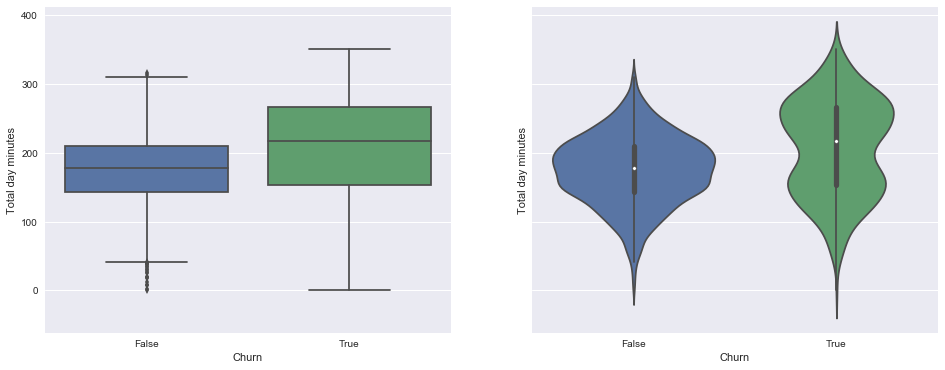

In [13]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(16, 6))

sns.boxplot(x='Churn', y='Total day minutes', data=df, ax=axes[0]);
sns.violinplot(x='Churn', y='Total day minutes', data=df, ax=axes[1]);

Теперь изобразим распределение числа обращений в сервисный центр (такую картинку мы строили в первой статье). Тут уникальных значений признака не много (признак можно считать как количественным целочисленным, так и порядковым), и наглядней изобразить распределение с помощью `countplot`. **Наблюдение:** доля оттока сильно возрастает начиная с 4 звонков в сервисный центр.

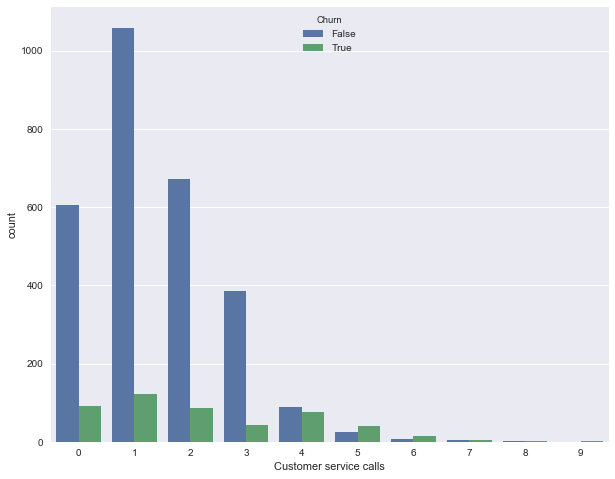

In [14]:
sns.countplot(x='Customer service calls', hue='Churn', data=df);

Теперь посмотрим на связь бинарных признаков *International plan* и *Voice mail plan* с оттоком. **Наблюдение**:  когда роуминг подключен, доля оттока намного выше, т.е. наличие междунароного роуминга – сильный признак. Про голосовую почту такого нельзя сказать. 

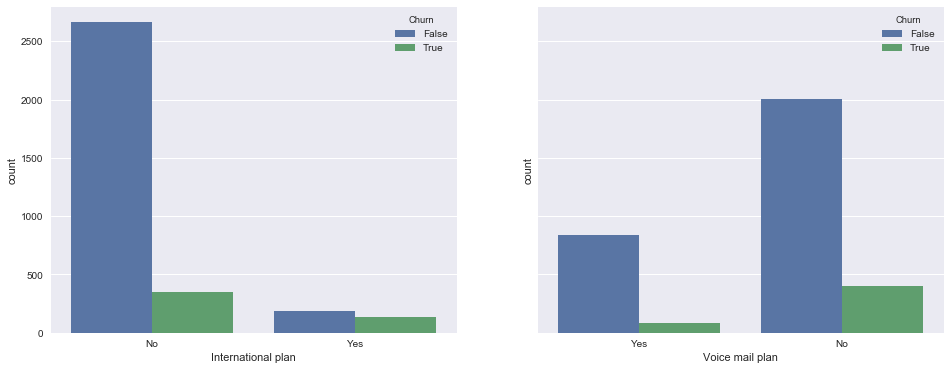

In [15]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(16,6))

sns.countplot(x='International plan', hue='Churn', data=df, ax=axes[0]);
sns.countplot(x='Voice mail plan', hue='Churn', data=df, ax=axes[1]);

Наконец, посмотрим, как с оттоком связан категориальный признак *State*. С ним уже не так приятно работать, поскольку число уникальных штатов довольно велико – 51. Можно в начале построить сводную табличку или посчитать процент оттока для каждого штата. Но мы видим, что данных по каждом штату по отдельности маловато (ушедших – всего от 3 до 17), поэтому, возможно, признак *State* впоследствии не стоит добавлять в модели классификации из-за риска *переобучения* (но мы это будем проверять на *кросс-валидации*, stay tuned!).

In [16]:
pd.crosstab(df['State'], df['Churn']).T

State,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,HI,IA,ID,IL,IN,KS,KY,LA,MA,MD,ME,MI,MN,MO,MS,MT,NC,ND,NE,NH,NJ,NM,NV,NY,OH,OK,OR,PA,RI,SC,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
Churn,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,49,72,44,60,25,57,62,49,52,55,46,50,41,64,53,62,57,51,47,54,53,49,57,69,56,51,54,57,56,56,47,50,56,52,68,68,52,67,37,59,46,52,48,54,62,72,65,52,71,96,68
True,3,8,11,4,9,9,12,5,9,8,8,3,3,9,5,9,13,8,4,11,17,13,16,15,7,14,14,11,6,5,9,18,6,14,15,10,9,11,8,6,14,8,5,18,10,5,8,14,7,10,9


Доли оттока для каждого штата:

In [17]:
df.groupby(['State'])['Churn'].agg([np.mean]).sort_values(by='mean', ascending=False).T

State,NJ,CA,TX,MD,SC,MI,MS,NV,WA,ME,MT,AR,KS,NY,MN,PA,MA,CT,NC,NH,GA,DE,OK,OR,UT,CO,KY,SD,OH,FL,IN,ID,WY,MO,VT,AL,NM,ND,WV,TN,DC,RI,WI,IL,NE,LA,IA,VA,AZ,AK,HI
mean,0.264706,0.264706,0.25,0.242857,0.233333,0.219178,0.215385,0.212121,0.212121,0.209677,0.205882,0.2,0.185714,0.180723,0.178571,0.177778,0.169231,0.162162,0.161765,0.160714,0.148148,0.147541,0.147541,0.141026,0.138889,0.136364,0.135593,0.133333,0.128205,0.126984,0.126761,0.123288,0.116883,0.111111,0.109589,0.1,0.096774,0.096774,0.09434,0.09434,0.092593,0.092308,0.089744,0.086207,0.081967,0.078431,0.068182,0.064935,0.0625,0.057692,0.056604


Видно, что в Нью-Джерси и Калифорнии доля оттока выше 25%, а на Гавайях и в Аляске меньше 5%. Но эти выводы построены на слишком скромной статистике и возможно, это просто особенности имеющихся данных (тут можно и гипотезы попроверять про корреляции Мэтьюса и Крамера, но это уже за рамками данной статьи).

Наконец построим t-SNE представление данных. Название метода сложное – t-distributed Stohastic Neighbor Embedding, математика тоже крутая (и вникать в нее не будем), но основная идея проста, как дверь: найдем такое отображение из многомерного признакового пространства на плоскость (или в 3D, но почти всегда выбирают 2D), чтоб точки, которые были далеко друг от друга, на плоскости тоже оказались удаленными, а близкие точки – также отобразились на близкие. То есть neighbor embedding – это своего рода поиск нового представления данных, при котором сохраняется соседство. 

Немного деталей: выкинем штаты и признак оттока, бинарные Yes/No-признаки переведем в числа (при помощи [`pandas.Series.map`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html)). Также нужно масштабировать выборку – из каждого признака вычесть его среднее и поделить на стандартное отклонение, это делае `StandardScaler`.

In [18]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [19]:
# преобразуем все признаки в числовые, выкинув штаты
X = df.drop(['Churn', 'State'], axis=1)
X['International plan'] = X['International plan'].map({'Yes': 1, 'No': 0})
X['Voice mail plan'] = X['Voice mail plan'].map({'Yes': 1, 'No': 0})

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [20]:
%%time
tsne = TSNE(random_state=17)
tsne_representation = tsne.fit_transform(X_scaled)

CPU times: user 19.2 s, sys: 2.32 s, total: 21.5 s
Wall time: 21 s


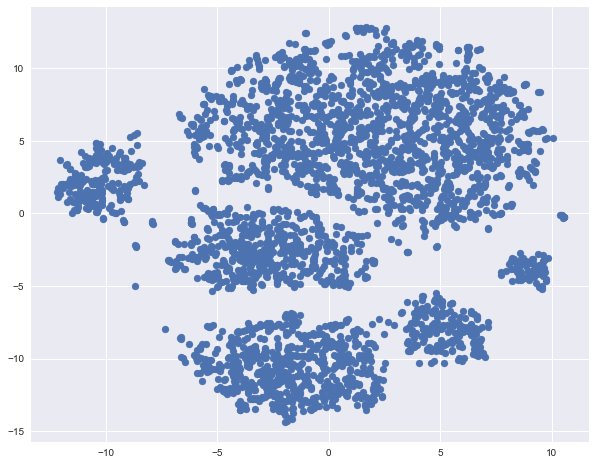

In [21]:
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1]);

Раскрасим полученное t-SNE представление данных по оттоку (синие – лояльные, оранжевые – ушедшие клиенты).

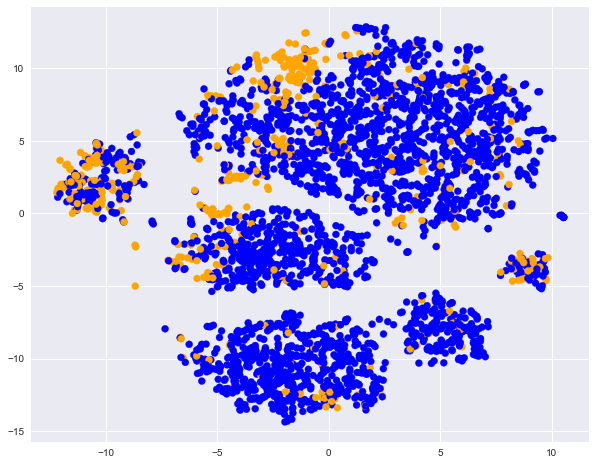

In [25]:
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1], 
            c=df['Churn'].map({0: 'blue', 1: 'orange'}));

Видим, что ушедшие клиенты преимущественно "кучкуются" в некоторых областях признакового пространства. 


Чтоб лучше понять картинку, можно также раскрасить ее по остальным бинарным признакам – по роумингу и голосовой почте. Синие участки соответствуют объектам, обладающим этим бинарным признаком.

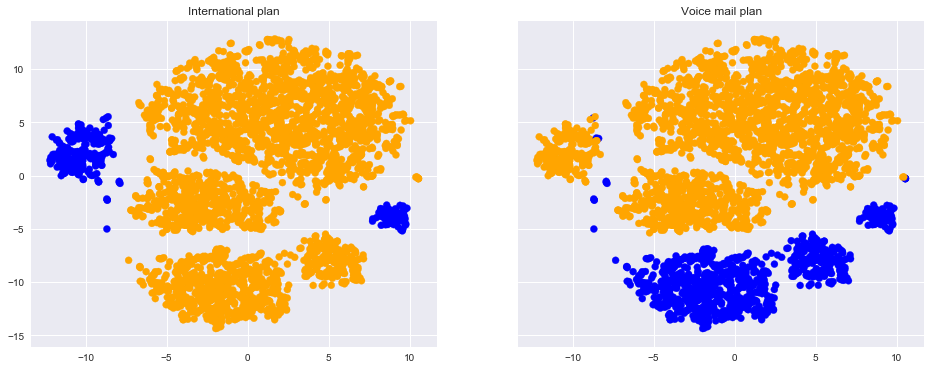

In [24]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(16,6))

axes[0].scatter(tsne_representation[:, 0], tsne_representation[:, 1], 
            c=df['International plan'].map({'Yes': 'blue', 'No': 'orange'}));
axes[1].scatter(tsne_representation[:, 0], tsne_representation[:, 1], 
            c=df['Voice mail plan'].map({'Yes': 'blue', 'No': 'orange'}));
axes[0].set_title('International plan');
axes[1].set_title('Voice mail plan');

Теперь понятно, что, например, много ушедших клиентов кучкуется в левом кластере людей с поключенным роумингом, но без голосовой почты. 

Напоследок отметим минусы t-SNE (да, по нему тоже лучше писать отдельную статью):
 - большая вычислительная сложность. Вот эта реализация sklearn скорее всего не поможет в Вашей реальной задаче, на выборках побольше стоит посмотреть в сторону [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE);
 - картинка может сильно поменяться при изменении `random seed`, это усложняет интерпретацию. [Вот](http://distill.pub/2016/misread-tsne/) хороший тьюториал по t-SNE. Но в целом по таким картинкам не стоит делать далеко идущих выводов – не стоит гадать по кофейной гуще. Иногда что-то бросается в глаза и подтверждается при изучении, но это не часто происходит.
 
Вот еще пара картинок. С помощью t-SNE можно действительно получить хорошее представление о данных (как в случае с рукописными цифрами, [вот](https://colah.github.io/posts/2014-10-Visualizing-MNIST/) хорошая статья), так и просто нарисовать елочную игрушку. 

<img src='../../img/tsne_mnist.png' />

<img src='../../img/tsne_christmas_toy.jpg'/>